In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm

In [ ]:
# !pip install statsmodels
# !pip install seaborn==0.11.0

# Cleaning

In [124]:
data_dir = 'jan_feb_data'
# report data
report = pd.read_csv(os.path.join(data_dir, "export_as_report.csv"))
cols_to_use = ['Ad ID', 'Ad Delivery', 'Last Significant Edit', 
              'Date Created', 'Starts', 'Reporting Ends',
              'Website Purchase ROAS (Return on Ad Spend)',
              'CPC (All) (USD)', 'CTR (All)',
              'Video Plays at 25%', 'Video Plays at 50%', 'Video Plays at 75%',
              'Video Plays at 95%', 'Video Plays at 100%', 'Video Average Play Time']
metrics = ['Website Purchase ROAS (Return on Ad Spend)',
           'CPC (All) (USD)', 'CTR (All)']
report = report[cols_to_use]

# campaign data
campaigns_data = ["jan-feb_4_campaigns_1-200.csv","jan-feb_4_campaigns_201-209.csv"]
camp = []
for cd in campaigns_data:
    camp.append(pd.read_csv(os.path.join(data_dir, cd)))
camp_data = pd.concat(camp)
camp_data = camp_data.dropna(axis='columns',how='all')
cols_to_use = ['Ad ID',
               'Ad Name','Ad Set Time Start',
               'Gender', 'Age Min', 'Age Max',
               'Messenger Positions',
               'Ad Status',
               'Ad Name', 'Title', 'Body', 'Display Link','Link Description',
               'Image Hash','Video Thumbnail URL']
camp_data = camp_data[cols_to_use]
# Clean up Ad ID column by removing the a: in the value
camp_data['Ad ID'] = camp_data['Ad ID'].apply(lambda a:int(a.split(":")[1]))

# merge the 2 dataframes
ad_data = report.merge(camp_data, on="Ad ID")

# remove duplicate columns
ad_data = ad_data.loc[:,~ad_data.columns.duplicated()]

def replace_nans(name):
    if str(name) == "nan":
        return 0
    else:
        return 1

ad_data['messenger_ad'] = ad_data['Messenger Positions'].apply(replace_nans)

# get image / video tag from the ad name
def process_ad_name(name):
    return name.split('_')[-1]
ad_data['media_type'] = ad_data['Ad Name'].apply(process_ad_name)

# Metrics Exploration

In [125]:
ad_data['ctr'] = ad_data['CTR (All)']
ad_data['cpc'] = ad_data['CPC (All) (USD)']
# transform to log scale
epsilon = 10e-2
ad_data['log_ctr'] = np.log(np.where(ad_data['ctr'] == 0, epsilon, ad_data['ctr']))
ad_data['log_cpc'] = np.log(np.where(ad_data['cpc'] == 0, epsilon, ad_data['cpc']))

In [126]:
ad_data[metrics].describe()

,Website Purchase ROAS (Return on Ad Spend),CPC (All) (USD),CTR (All)
count,99.000000,209.000000,209.000000
mean,1.446342,1.553722,0.965940
std,1.626405,1.178083,1.191042
min,0.085415,0.000000,0.000000
25%,0.640574,0.482581,0.475534
50%,0.975858,1.634286,0.839944
75%,1.721293,2.233000,1.258993
max,12.480499,5.875000,14.285714


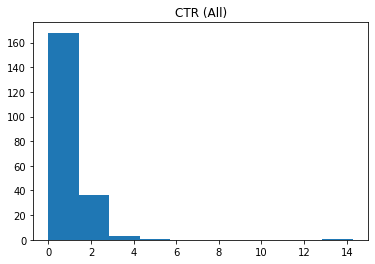

In [127]:
plt.hist(ad_data['ctr'])
plt.title('CTR (All)')
plt.show()

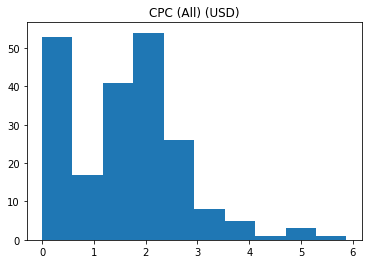

In [128]:
plt.hist(ad_data['cpc'])
plt.title('CPC (All) (USD)')
plt.show()

Notes: Outlier in CPC (manual exploration shows its a high quality GIF, keep it). Use log scale for both metrics. ROA has missing vals so don't use for now.

# Media Exploration

In [129]:
df_media = ad_data[['log_cpc', 'cpc', 'log_ctr', 'ctr', "media_type"]]
df_media.media_type.value_counts()

Static        96
GIF           92
Video         20
Collection     1
Name: media_type, dtype: int64

In [130]:
df_media = df_media[df_media.media_type != 'Collection']

In [131]:
X_bin = pd.get_dummies(df_media.media_type, columns=["media_type"])[['Video', 'GIF']]

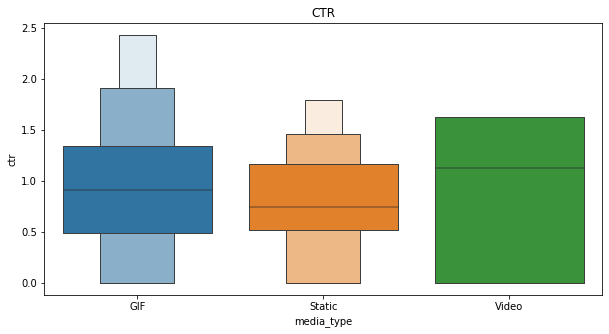

In [132]:
plt.figure(figsize=(10, 5))
ax = sns.boxenplot(x='media_type', y='ctr', data=df_media, showfliers=False)
ax.set_title('CTR')
plt.show()

In [133]:
ctr = df_media.ctr
model_ctr = sm.OLS(ctr, X_bin).fit()
model_ctr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    ctr   R-squared (uncentered):                   0.282
Model:                            OLS   Adj. R-squared (uncentered):              0.275
Method:                 Least Squares   F-statistic:                              40.54
Date:                Sun, 07 Mar 2021   Prob (F-statistic):                    1.42e-15
Time:                        17:46:05   Log-Likelihood:                         -349.75
No. Observations:                 208   AIC:                                      703.5
Df Residuals:                     206   BIC:                                      710.2
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Video          1.0604      0.292      3.630      0.000       0.484       1.636
GIF            1.1226      0.136      8.241      0.000       0.854       1.391
==============================================================================
Omnibus:                      265.684   Durbin-Watson:                   1.663
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23576.790
Skew:                           5.199   Prob(JB):                         0.00
Kurtosis:                      54.110   Cond. No.                         2.14
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

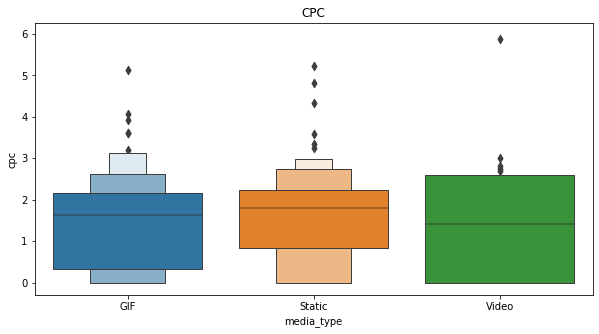

In [134]:
plt.figure(figsize=(10, 5))
ax = sns.boxenplot(x='media_type', y='cpc', data=df_media, showfliers=True)
ax.set_title('CPC')
plt.show()

Notes: There is only one collection, so drop it and focus on GIFs, video, static.

In [135]:
cpc = df_media.cpc
model_cpc = sm.OLS(cpc, X_bin).fit()
model_cpc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    cpc   R-squared (uncentered):                   0.316
Model:                            OLS   Adj. R-squared (uncentered):              0.309
Method:                 Least Squares   F-statistic:                              47.48
Date:                Sun, 07 Mar 2021   Prob (F-statistic):                    1.10e-17
Time:                        17:46:08   Log-Likelihood:                         -394.92
No. Observations:                 208   AIC:                                      793.8
Df Residuals:                     206   BIC:                                      800.5
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Video          1.5064      0.363      4.150      0.000       0.791       2.222
GIF            1.4924      0.169      8.817      0.000       1.159       1.826
==============================================================================
Omnibus:                        2.057   Durbin-Watson:                   1.014
Prob(Omnibus):                  0.358   Jarque-Bera (JB):                2.134
Skew:                           0.223   Prob(JB):                        0.344
Kurtosis:                       2.781   Cond. No.                         2.14
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Targeting Exploration

In [136]:
def target_subsetter(gender,age):
    # says ad is targetted if gender is women and min age is 24
    if gender != "All" and age > 18:
        return 1
    else:
        return 0

ad_data["targeted"] = ad_data.apply(lambda x: target_subsetter(x['Gender'], x['Age Min']), axis=1)

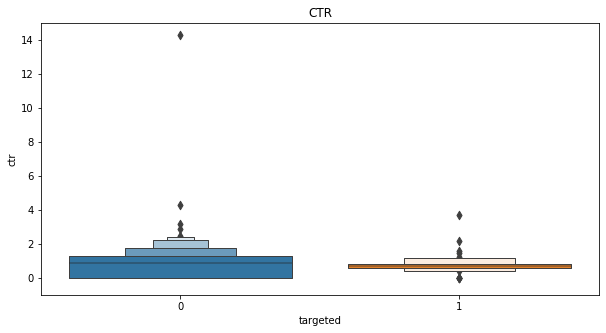

In [137]:
plt.figure(figsize=(10, 5))
ax = sns.boxenplot(x='targeted', y='ctr', data=ad_data)
ax.set_title('CTR')
plt.show()

In [138]:
model_ctr = sm.OLS(ad_data["ctr"],ad_data["targeted"]).fit()
model_ctr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    ctr   R-squared (uncentered):                   0.047
Model:                            OLS   Adj. R-squared (uncentered):              0.043
Method:                 Least Squares   F-statistic:                              10.35
Date:                Sun, 07 Mar 2021   Prob (F-statistic):                     0.00150
Time:                        17:46:12   Log-Likelihood:                         -380.54
No. Observations:                 209   AIC:                                      763.1
Df Residuals:                     208   BIC:                                      766.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
targeted       0.8146      0.253      3.217      0.002       0.315       1.314
==============================================================================
Omnibus:                      297.532   Durbin-Watson:                   1.112
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36346.456
Skew:                           6.220   Prob(JB):                         0.00
Kurtosis:                      66.395   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

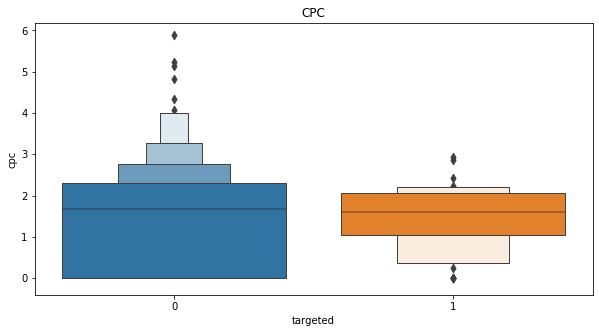

In [139]:
plt.figure(figsize=(10, 5))
ax = sns.boxenplot(x='targeted', y='cpc', data=ad_data)
ax.set_title('CPC')
plt.show()

In [140]:
model_cpc = sm.OLS(ad_data["cpc"],ad_data["targeted"]).fit()
model_cpc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    cpc   R-squared (uncentered):                   0.098
Model:                            OLS   Adj. R-squared (uncentered):              0.093
Method:                 Least Squares   F-statistic:                              22.49
Date:                Sun, 07 Mar 2021   Prob (F-statistic):                    3.92e-06
Time:                        17:46:13   Log-Likelihood:                         -425.21
No. Observations:                 209   AIC:                                      852.4
Df Residuals:                     208   BIC:                                      855.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
targeted       1.4871      0.314      4.742      0.000       0.869       2.105
==============================================================================
Omnibus:                        7.607   Durbin-Watson:                   0.449
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                7.393
Skew:                           0.443   Prob(JB):                       0.0248
Kurtosis:                       3.255   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Messenger vs fb/insta

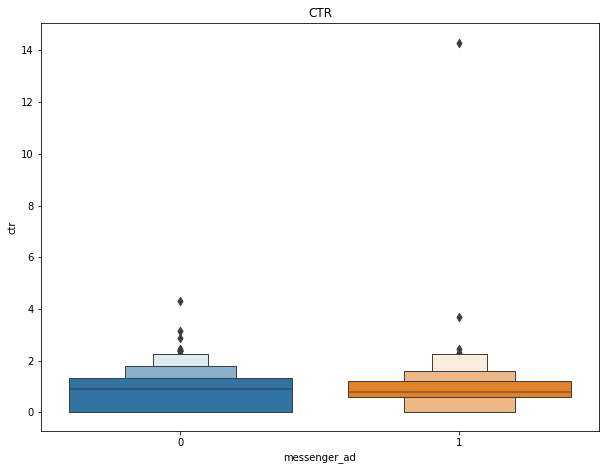

In [148]:
plt.figure(figsize=(10, 7.5))
ax = sns.boxenplot(x='messenger_ad', y='ctr', data=ad_data)
ax.set_title('CTR')
plt.show()

In [143]:
model_ctr = sm.OLS(ad_data["ctr"],ad_data["messenger_ad"]).fit()
model_ctr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    ctr   R-squared (uncentered):                   0.205
Model:                            OLS   Adj. R-squared (uncentered):              0.202
Method:                 Least Squares   F-statistic:                              53.80
Date:                Sun, 07 Mar 2021   Prob (F-statistic):                    4.88e-12
Time:                        17:48:11   Log-Likelihood:                         -361.58
No. Observations:                 209   AIC:                                      725.2
Df Residuals:                     208   BIC:                                      728.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
messenger_ad     1.0406      0.142      7.335      0.000       0.761       1.320
==============================================================================
Omnibus:                      260.355   Durbin-Watson:                   1.325
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19850.245
Skew:                           5.048   Prob(JB):                         0.00
Kurtosis:                      49.664   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

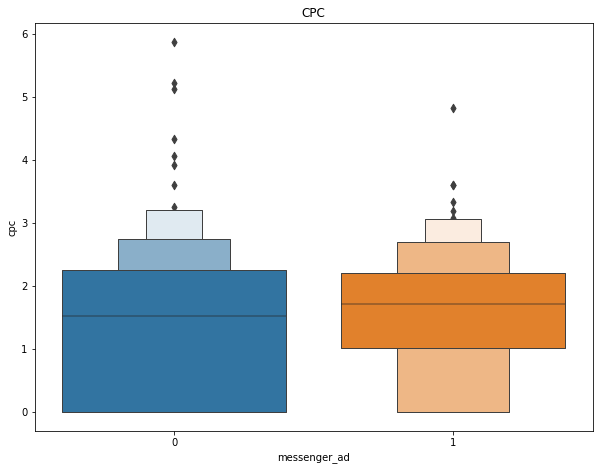

In [149]:
plt.figure(figsize=(10, 7.5))
ax = sns.boxenplot(x='messenger_ad', y='cpc', data=ad_data)
ax.set_title('CPC')
plt.show()

In [150]:
model_cpc = sm.OLS(ad_data["cpc"],ad_data["messenger_ad"]).fit()
model_cpc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    cpc   R-squared (uncentered):                   0.309
Model:                            OLS   Adj. R-squared (uncentered):              0.306
Method:                 Least Squares   F-statistic:                              93.17
Date:                Sun, 07 Mar 2021   Prob (F-statistic):                    1.89e-18
Time:                        17:49:40   Log-Likelihood:                         -397.26
No. Observations:                 209   AIC:                                      796.5
Df Residuals:                     208   BIC:                                      799.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
messenger_ad     1.6243      0.168      9.652      0.000       1.293       1.956
==============================================================================
Omnibus:                       12.996   Durbin-Watson:                   0.585
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.865
Skew:                           0.550   Prob(JB):                     0.000975
Kurtosis:                       3.619   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Component Importance

In [78]:
def get_top_cats(df, colname, k=5):
    return df[colname].value_counts().head(k).index.tolist()
def make_top_dummies(df, old_colname, new_colname, k=5):
    topcats = get_top_cats(df, old_colname, k)
    df_new = pd.DataFrame({'Ad ID': df['Ad ID']})
    for i, cat in enumerate(topcats):
        dummy_colname = new_colname + '_' + str(i)
        df_new[dummy_colname] = np.where(df[old_colname]==cat, 1, 0)
    return df_new

In [79]:
img_d = make_top_dummies(ad_data, 'Image Hash', 'img', 5)
vid_d = make_top_dummies(ad_data, 'Video Thumbnail URL', 'vid', 5)
title_d = make_top_dummies(ad_data, 'Title', 'title', 5)
body_d = make_top_dummies(ad_data, 'Body', 'body', 5)

In [86]:
# join into df
df_component = ad_data[['Ad ID', 'ctr', 'cpc']]
for d in ['img_d', 'vid_d', 'title_d', 'body_d']:
    df_component = df_component.merge(eval(d), on="Ad ID")
    
del df_component['Ad ID']
X = df_component[df_component.columns.difference(['ctr', 'cpc'])]

In [106]:
# cpc = df_component.cpc
# model_cpc = sm.OLS(cpc, X).fit()
# model_cpc.summary()

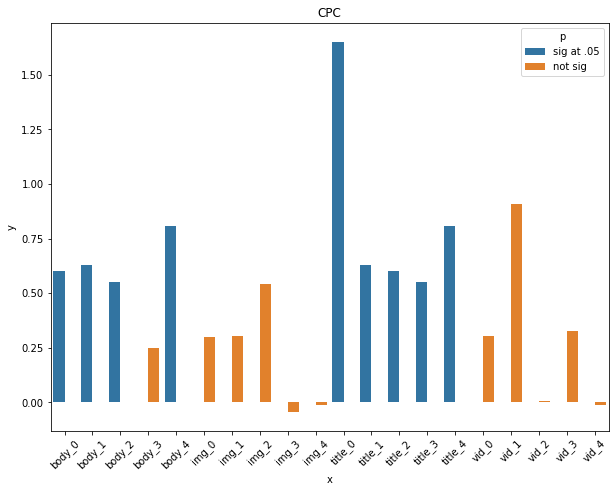

In [116]:
x = model_cpc.params.index.tolist()
y = model_cpc.params.tolist()
p = np.where(np.array(model_cpc.pvalues.tolist()) <= .05, "sig at .05", "not sig")
df_cpc = pd.DataFrame({'x': x, 'y': y, 'p': p})

plt.figure(figsize=(10, 7.5))
ax = sns.barplot(x = 'x',y = 'y',hue = 'p', data = df_cpc)
ax.set_title('CPC')
plt.xticks(rotation=45)
plt.show()

In [113]:
# ctr = df_component.ctr
# model_ctr = sm.OLS(ctr, X).fit()
# model_ctr.summary()

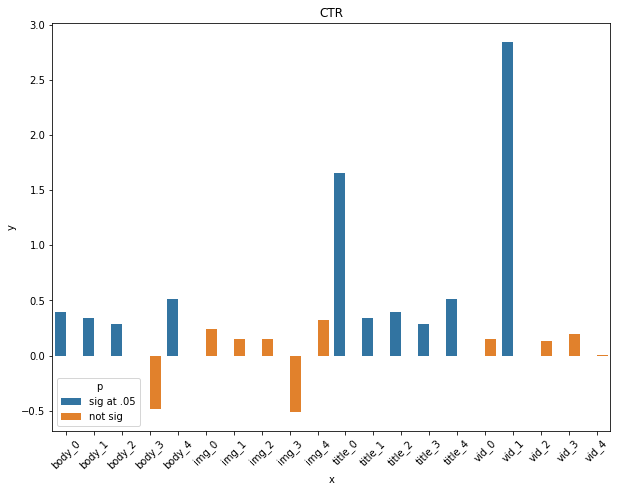

In [115]:
x = model_ctr.params.index.tolist()
y = model_ctr.params.tolist()
p = np.where(np.array(model_ctr.pvalues.tolist()) <= .05, "sig at .05", "not sig")
df_ctr = pd.DataFrame({'x': x, 'y': y, 'p': p})

plt.figure(figsize=(10, 7.5))
ax = sns.barplot(x = 'x',y = 'y',hue = 'p', data = df_ctr)
ax.set_title('CTR')
plt.xticks(rotation=45)
plt.show()